In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import numba
import seaborn as sns
sns.set(style='ticks', context='paper', font_scale=2)
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)
from IPython.display import display_latex

import sys
sys.path.append('../src/')
from simulation import *
from plots import *

In [4]:
from sympy import *
init_printing()

In [5]:
from rakott.mpl import fig_xlabel, fig_ylabel, fig_panel_labels

# Recurrence illustration

In [13]:
@numba.jit()
def recurrence(x, ρ, wA, wB, N=0):
    N = int(N)
    w = x * wA + (1 - x) * wB
    x = x * (1 - ρ + ρ * wA/w)
    if N > 0:
        x = np.random.binomial(N, x) / N
    return x

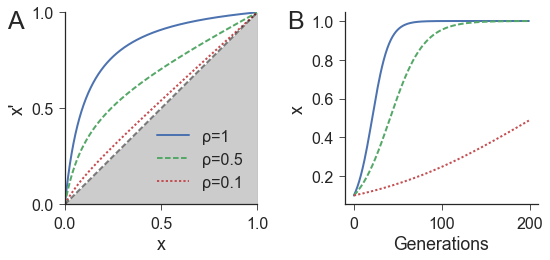

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
x = np.linspace(0, 1, 10000)
ρs = [1, 0.5, 0.1]
W = 1
w = 0.9

for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    xx = recurrence(x, ρ=ρ, wA=1.0, wB=0.1)
    ax.plot(x, xx, lw=2, ls=ls, label='ρ={}'.format(ρ))
ax.plot(x, x, ls='--', alpha=0.5, lw=2, color='k')
ax.fill_between(x, x, color='k', alpha=0.2)

ax.set(
    xlabel='x',
    ylabel='x\'',
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.linspace(0, 1, 3),
    yticks=np.linspace(0, 1, 3),
)
ax.legend()

ax = axes[1]
n = 200
for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    x = np.empty(n)
    x[0] = 0.1
    for t in range(1, n):        
        x[t] = recurrence(x[t - 1], ρ, W, w)
    ax.plot(x, lw=2, ls=ls, label='ρ={}'.format(ρ))

# ax.legend()
ax.set_xlabel('Generations')
ax.set_ylabel('x')
fig_panel_labels(axes, xcoord=-0.3)
fig.tight_layout()
sns.despine()

fig.savefig('../figures/recurrence_example.pdf', dpi=300)
fig.savefig('../figures/recurrence_example.png', dpi=300)

In [627]:
from PIL import Image

im = Image.open('../figures/recurrence_example.png')
w, h = im.size
im.crop((0, 0, w/2, h)).save('../figures/recurrence_example_A.png')
im.crop((w/2, 0, w, h)).save('../figures/recurrence_example_B.png')

# Environment A1B1

In [16]:
def x_star(W, w, ρ):
    return 0.5 - (W + w - np.sqrt( (1 - ρ)**2 * (W - w)**2 + 4 * W * w ))/(2 * (2 - ρ) * (W - w))

In [153]:
W = 1
ss = np.logspace(-3, -0.01, 101)
ρs = np.linspace(0, 1, 101)

x = np.array([
    [
        x_star(W, w, ρ)
        for ρ in ρs
    ]
    for w in ws
])

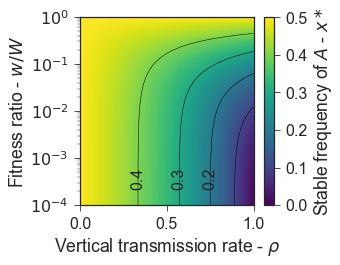

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.pcolormesh(ρs, ws, x, cmap='viridis', vmin=0, vmax=0.5)
cntr = ax.contour(ρs, ws, x, levels=np.arange(0, 1.1, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525',use_clabeltext=True)
plt.colorbar(im, ax=ax, label='Stable frequency of $A$ - $x*$')
ax.set(
    yscale='log',
    xlabel=r'Vertical transmission rate - $\rho$',
    ylabel=('Fitness ratio - $w/W$')
)
fig.tight_layout()
fig.savefig('../figures/A1B1_stable_x.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
fig.savefig('../figures/A1B1_stable_x.png', bbox_inches='tight')#, bbox_extra_artists=txt)

In [155]:
wbar = np.array([
    [
        x_star(W, w, ρ) * (W - w) + w
        for ρ in ρs
    ]
    for w in ws
])

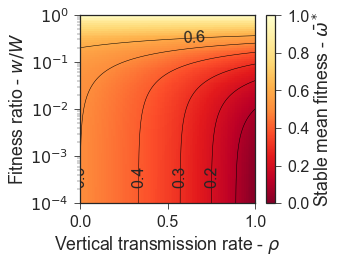

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.pcolormesh(ρs, ws, wbar, cmap='YlOrRd_r', vmin=0, vmax=1)
cntr = ax.contour(ρs, ws, wbar, levels=np.arange(0, 0.7, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525', use_clabeltext=True)
plt.colorbar(im, ax=ax, label=r'Stable mean fitness - $\bar{\omega}^*$')
ax.set(
    yscale='log',
    xlabel=r'Vertical transmission rate - $\rho$',
    ylabel=('Fitness ratio - $w/W$')
)

fig.tight_layout()

fig.savefig('../figures/A1B1_mean_fitness.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
fig.savefig('../figures/A1B1_mean_fitness.png', bbox_inches='tight')#, bbox_extra_artists=txt)

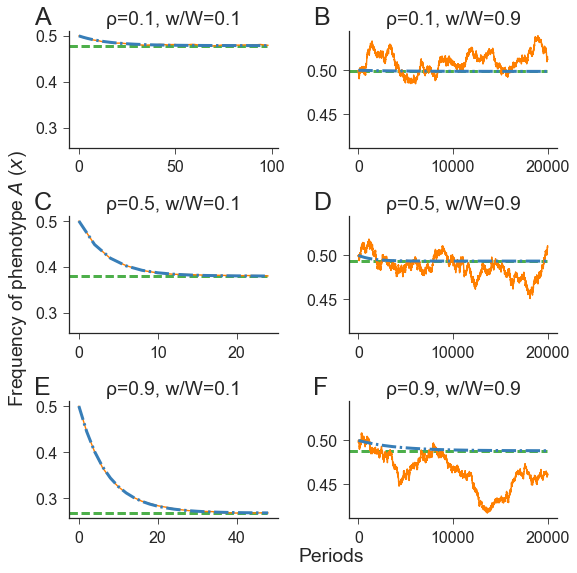

In [197]:
N = 10000
ns = np.array([[100, 20000], [25, 20000], [50, 20000]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey='col')

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 2)
        # analytic solution
        sol = x_star(W_, w_, ρ_)
        ax.axhline(y=sol, xmin=0, xmax=0.95, color=green, lw=3, ls='--', label='Equilibrium')        
        # WF
        reps = 100
        y_ = np.empty(n, float)
        y_[0] = 0.5
        x_ = np.empty((n, reps))
        x_[0, :] = 0.5
        for t in range(1, n):
            wA, wB = (w_, W_) if t % 2 == 0 else (W_, w_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
            x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB, N)
        ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Finite population')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-.', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.legend().set_visible(False)

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ ($x$)', xcoord=0.025)
fig_panel_labels(axes, ycoord=1.05)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A1B1.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight');

# Environment A1B2

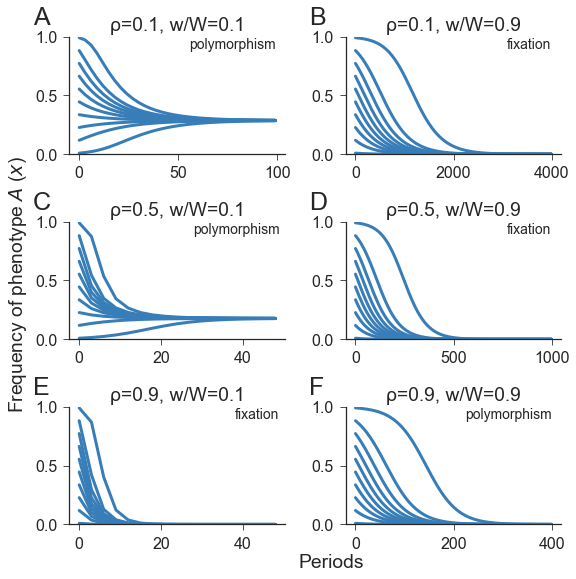

In [216]:
N = 10000
ns = np.array([[100, 4000], [50, 1000], [50, 400]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey="col")

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 3)
        # WF
        reps = 100
        x_ = np.empty((n, reps), float)
        x_[0, :] = 0.5
        y_ = np.empty((n, 10), float)
        y_[0, :] = np.linspace(0.01, 0.99, 10)
        for t in range(1, n):
            wA, wB = (W_, w_) if t % 3 == 2 else (w_, W_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
            x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB, N)
#         ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Finite population')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.set_ylim(0, 1)
        ax.legend().set_visible(False)
        if (x_[-1,:] == 0).all():
            ax.text(t, 0.9, 'fixation', fontdict=dict(fontsize=14, horizontalalignment='right'))
        else:
            ax.text(t, 0.9, 'polymorphism', fontdict=dict(fontsize=14, horizontalalignment='right'))

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ ($x$)', xcoord=0.025)
fig_panel_labels(axes, ycoord=1.1)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A1B2.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight');

# Environment ABBABB

In [9]:
# a = (1-ρ)*(W-w)
# b = ρ*W + (1-ρ)*w
# c = W-w
# d = w
# e = -a
# f = ρ*w + (1-ρ)*W
# g = -c
# h = W

In [10]:
a,b,c,d,e,f,g,h = symbols('a,b,c,d,e,f,g,h'.replace(',', ' '))
x, ρ, W, w = symbols('x ρ W w')

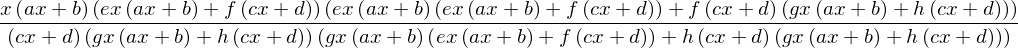

In [11]:
x1 = x*(a*x+b)/(c*x+d)
x2 = x1*(e*x1+f)/(g*x1+h)
x3 = x2*(e*x2+f)/(g*x2+h)
x3 = simplify(x3)
x3

In [16]:
x3num, x3denom = x3.as_numer_denom()
pol = (x3denom*x - x3num).subs(dict(
    e = -a,
    f = ρ*w + (1-ρ)*W,
    g = -c,
    h = W
)).subs(dict(
    a = (1-ρ)*(W-w),
    b = ρ*W + (1-ρ)*w,
    c = W-w,
    d = w,
)).as_poly(x)

In [17]:
pol.degree(), len(pol.all_coeffs())

In [18]:
pol(0), pol(1)

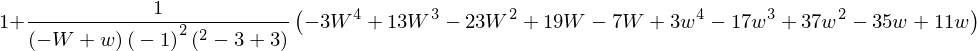

In [19]:
import sympy
sympy.polys.rootoftools.RootSum(pol)

In [20]:
from ipywidgets import interact

In [ ]:
pol_roots = np.array(sympy.polys.rootoftools.roots(pol.subs({W:1, w:0.41, ρ:0.77}).as_poly(x), multiple=True), dtype=float)
pol_roots

In [497]:
@interact(w_=(0,1, 0.01), ρ_=(0,1, 0.01))
def _(w_, ρ_):
    pol_roots = np.array(sympy.polys.rootoftools.roots(
        pol.subs({W:1, w:w_, ρ:ρ_}).as_poly(x), multiple=True, filter='R'
    ))
    pol_roots = pol_roots[np.isreal(pol_roots)].astype(float)
    idx = (pol_roots > 0) & (pol_roots < 1) & (~np.isclose(pol_roots, 1)) & (~np.isclose(pol_roots, 0))
    print(pol_roots[idx])

[ 0.00439187]


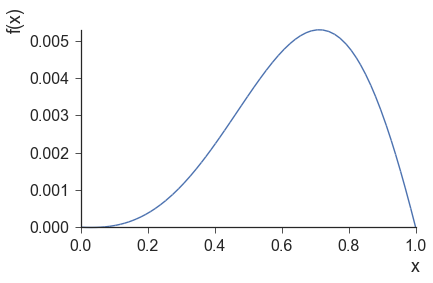

In [509]:
@interact(w_=(0,1, 0.01), ρ_=(0,1, 0.01))
def _(w_, ρ_):
    plot(pol.subs({W:1, w:w_, ρ:ρ_}), (x, 0, 1))

In [21]:
roots_table = []
for w_ in np.linspace(0, 1, 50):
    for ρ_ in np.linspace(0, 1, 50):
        pol_roots = np.array(sympy.polys.rootoftools.roots(
            pol.subs({W:1, w:w_, ρ:ρ_}).as_poly(x), multiple=True, filter='R'
        ))
        pol_roots = pol_roots[np.isreal(pol_roots)].astype(float)
        idx = (pol_roots > 0) & (pol_roots < 1) & (~np.isclose(pol_roots, 1)) & (~np.isclose(pol_roots, 0))
        pol_roots = pol_roots[idx]
        if len(pol_roots) > 1:
            print("More than 1! w={}, ρ={}".format(w_, ρ_))
        if len(pol_roots) == 1:
            roots_table.append({'w':w_, 'ρ':ρ_, 'root':pol_roots[0]})
        else:
            roots_table.append({'w':w_, 'ρ':ρ_, 'root': np.nan})

In [22]:
import pandas as pd
roots_df = pd.DataFrame(roots_table)
roots_df.head()

,root,w,ρ
0,NaN,0.0,0.000000
1,0.326484,0.0,0.020408
2,0.319543,0.0,0.040816
3,0.312509,0.0,0.061224
4,0.305384,0.0,0.081633


In [23]:
pivoted = roots_df.pivot('w', 'ρ', 'root')
np.isfinite(pivoted.values).all()

False

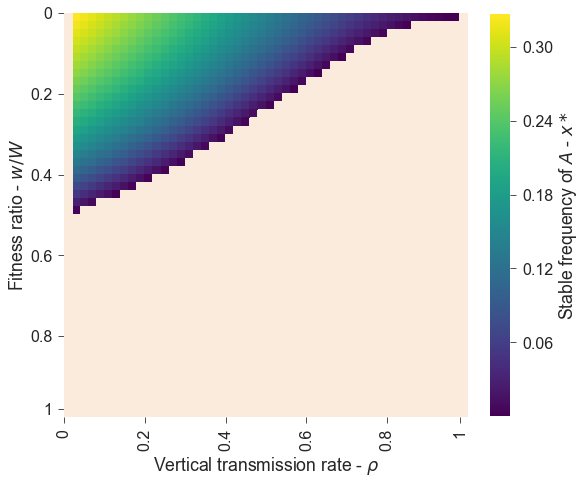

In [28]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(pivoted, square=True, ax=ax, cmap='viridis', 
            cbar_kws=dict(fraction=0.045, label='Stable frequency of $A$ - $x*$'))
plt.colorbar
sns.heatmap(~np.isfinite(pivoted), mask=np.isfinite(pivoted), square=True, ax=ax, cbar=False)
# cntr = ax.contourf(pivoted)
# ax.clabel(cntr, colors='w')
ax.set_xticks([0, 10, 20, 30, 40, 49])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40, 49])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

ax.set_xlabel(r'Vertical transmission rate - $\rho$')
ax.set_ylabel(r'Fitness ratio - $w/W$')
# ax.set_title(r'Polymorphism frequency in ABB - $x^*$')

fig.savefig('../figures/A1B2_polymorphism_')

# Environment AkBl

In [80]:
@numba.jit()
def recurrence(x, ρ, wA, wB, N=0):
    N = int(N)
    x = ρ * x * (wA / (wA * x + wB * (1 - x))) + (1-ρ) * x
#     if N > 0:
#         x = np.random.binomial(N, x) / N
    return x

In [103]:
import itertools as it

def simulation(x0, ρ, W, w, k, l, n, N=0):
    x0 = np.array(x0, ndmin=1)
    assert x0.ndim <= 1
    x = np.empty((n * (k + l) + 1, x0.shape[0]), dtype=float)
    x[0, :] = x0

    wAs = it.cycle(it.chain(it.repeat(W, k), it.repeat(w, l)))
    wBs = it.cycle(it.chain(it.repeat(w, k), it.repeat(W, l)))

    for t, wA, wB in zip(range(1, x.shape[0]), wAs, wBs):
        x[t, :] = recurrence(x[t - 1, :], ρ, wA, wB, N)
    
    return x